# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.interpolate import interp1d
from scipy.optimize import minimize
sys.path.append('documents/BNL/jupyter/notebooks/calibrator')
os.environ['LUSEE_DRIVE_DIR']='/home/anze/work/lusee/Drive/'
from algorithms import  Comb, Calibrator

In [2]:
# load in luseepy
current_dir = os.getcwd()

# Get the path to BNL/jupyter directory
jupyter_dir = os.path.abspath(os.path.join(current_dir, '../..'))
# Append the jupyter directory to the system path
sys.path.append(jupyter_dir)

import luseepy
from luseepy import lusee

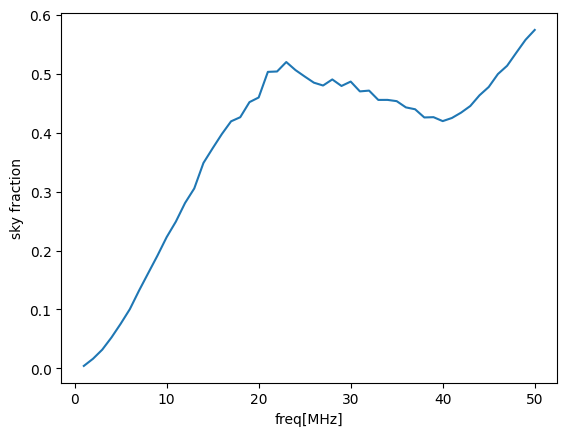

In [3]:
B=lusee.Beam()
plt.plot(B.freq,B.sky_fraction())
plt.xlabel('freq[MHz]')
plt.ylabel('sky fraction')
sky_fraction = interp1d(B.freq,B.sky_fraction(),kind='linear')




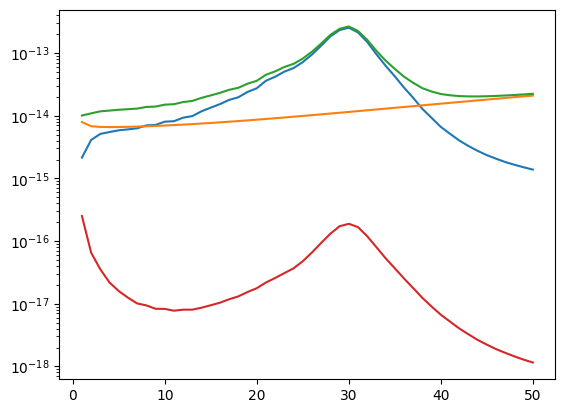

In [8]:
T=lusee.Throughput()

B2T = 3e8**2/(2*1.38e-23*B.freq**2)
Nsky = np.array(T.T2Vsq(B.freq)*lusee.MonoSkyModels.T_NB(B.freq)*sky_fraction(B.freq)*25e3/(16))
Namp = np.array(T.noise(B.freq)*25e3/16)
Bw = 100e3/400 # as per gina
lmb = 3e8/(B.freq*1e6)
X = lmb**2/(4*np.pi)
kb = 1.38e-23
A = np.array(np.ones(len(B.freq))*1e-22*Bw*X*T.T2Vsq(B.freq)/kb)
plt.plot(B.freq,Nsky)
plt.plot(B.freq,Namp)
plt.plot(B.freq,Nsky+Namp)
plt.plot(B.freq,A)
plt.semilogy()
Ai = interp1d(B.freq,A,kind='linear')
Ni = interp1d(B.freq,Nsky+Namp,kind='linear')



In [13]:
kar = np.arange(181,181+410*2,2)
freq = kar*50e3
print (freq.min(),freq.max(),len(freq))
As = np.sqrt(Ai(freq/1e6)) # amplitude not power
Ns = np.sqrt(Ni(freq/1e6)) # sigma not sigma^2

9050000.0 49950000.0 410


In [16]:
np.save('As.npy',As)
np.save('Ns.npy',Ns)
np.save('kar',kar)

Power per tone 4.999999999999999e-19 W/m^2


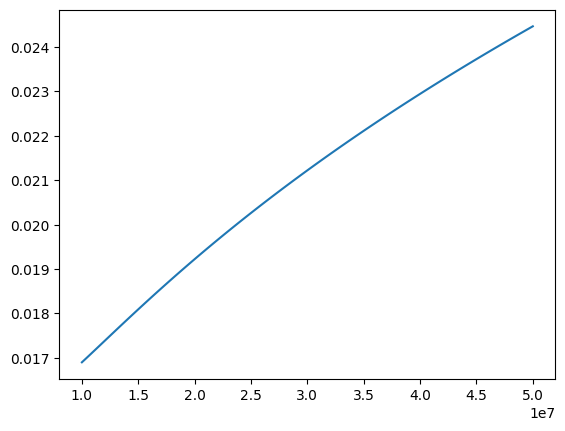

In [14]:
# define signal and sky signals
req_level = 5e-24 * 100e3 ## Appendix A requirement W/m^2 /Hz * 100kHz

print ("Power per tone",req_level,'W/m^2')

def signal_rms(freq):
    freq_MHz = freq/1e6
    sf = sky_fraction(freq_MHz)
    return np.sqrt(req_level*sf)

def noise_rms(freq):
    freq_MHz = freq/1e6
    channel_width = 25e3 ## 25kHz primary channelization
    sf = sky_fraction(freq_MHz)
    sky_area = 2*np.pi
    sky_signal =  lusee.MonoSkyModels.B_NB(freq_MHz)*sf*channel_width*sky_area
    return np.sqrt(sky_signal)

freq=np.linspace(10e6,50e6,100)
plt.plot(freq,signal_rms(freq)/noise_rms(freq))
#plt.plot(freq,noise(freq))

In [16]:
precompensation = np.load('precompensation.npz')['precomp']
antenna = 1/np.copy(precompensation)
x= np.arange(512)

init_params = [230, 20]


def pwr_filt(x, center, width): # power filter
    return 1 + 60 * np.exp(-(x - center)**2 / (2 * width**2))

def func(params): # define function for maximizing
    center, width = params
    modifier = pwr_filt(x, center, width)
    precompensation_fix = precompensation * modifier
    precompensation_fix /= np.sum(precompensation_fix)  # Normalize the filter
    boosted_signal = precompensation_fix * antenna
    return -np.sum(boosted_signal)  # Negate because we use minimize

# Perform the optimization
result = minimize(func, init_params, bounds=[(0, 511), (1, 100)])
optm_center, optm_width = result.x
optm_modifier = pwr_filt(x, optm_center, optm_width)

print(f"Optimized Center: {optm_center}, Optimized Width: {optm_width}")

Optimized Center: 207.08081850095226, Optimized Width: 22.25212489443238


In [17]:
precompensation_fix = precompensation * optm_modifier
precompensation_fix/=precompensation_fix.sum()
precompensation.sum()

0.999996529940528

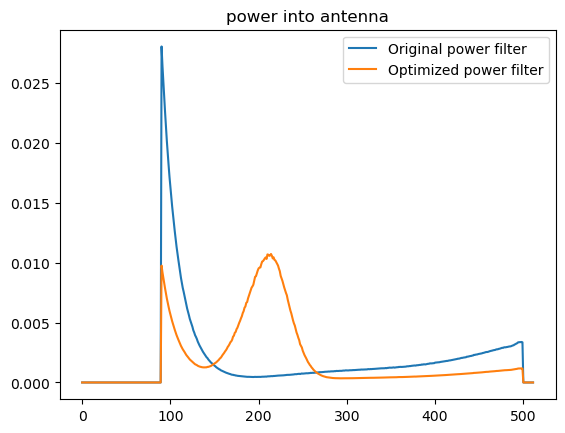

In [18]:
plt.title('power into antenna')
plt.plot(x, precompensation, label='Original power filter')
plt.plot(x, precompensation_fix, label='Optimized power filter')
plt.legend()


2.6212032695060046


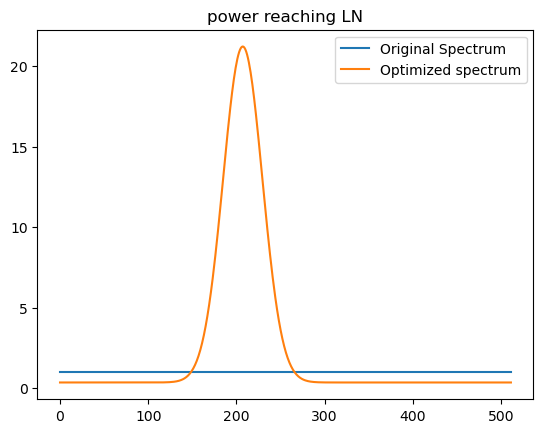

In [19]:
plt.title('power reaching LN')
plt.plot(precompensation*antenna,label='Original Spectrum')
plt.plot(precompensation_fix*antenna,label='Optimized spectrum')
plt.legend()
print ((precompensation_fix*antenna).sum()/(precompensation*antenna).sum())

In [20]:
comb=Comb(Nstart= 181, Nend= 983, response=signal_rms, noise=noise_rms, precompensation=precompensation_fix, antenna=antenna)
C = Calibrator(comb, alpha=-0.3,dalpha_dt=0.0, add_noise=True, Nnotch=16, Nintg=128)
#C.produce_data_block()[:,0]
res = C.analyze_data(alpha_start=-0.3,tmax=3,force_detect=True)
res['detect'], res['SNRdBdet']

FD mean: 5.927908006121436e-11 SD mean: -0.0013573109812849951
1.0053096491487338e-05


(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([5.97146857, 6.62149501, 6.16356729, 6.38644042, 6.29861431,
        5.86309734, 5.94999236, 5.44266607, 5.66616144, 6.32980873,
        6.16664959, 5.80482507, 6.53552675, 6.53283207, 6.15287749,
        5.7560249 , 6.4173    , 6.15443055, 6.00098603, 6.02463236,
        6.4895262 , 6.28188547, 6.45276278, 6.28208781, 6.26509141,
        5.773926  , 6.19635543, 6.19680064, 6.24500067, 6.27932322,
        6.35855873, 6.43751895, 5.96483823, 6.58122765, 5.90008581,
        6.17992098, 6.35722031]))

rms= 0.007043206223775096


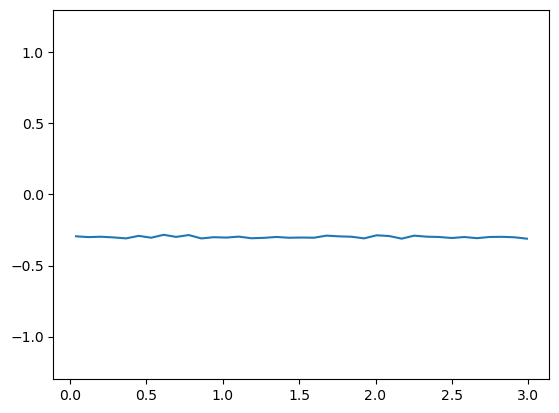

In [21]:
plt.plot(res['t'], res['alphadet'])
plt.ylim(-1.3,1.3)

print('rms=',res['alphadet'].std())

In [ ]:
comb=Comb(Nstart= 181, Nend= 983, response=signal_rms, noise=noise_rms,pilot_idx=[300],pilot_boost=15)
C = Calibrator(comb, alpha=-0.4,dalpha_dt=0.0, add_noise=True, Nnotch=256, Nintg=4)
wb,nb = C.analyze_data_incoherent()

In [ ]:
plt.plot(nb/wb)
